In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import duckdb
from pathlib import Path

DATA = Path("../..").resolve() / "data"
DATA

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PosixPath('/home/andy/frequency_model/data')

In [2]:
df = duckdb.sql(f"from read_csv_auto('{DATA.as_posix()}/other_liability_data_clean.csv')").to_df()
df['paid_rpt_ratio'] = df['paid_loss'] / df['reported_loss']
df['loss_ratio'] = df['incurred_loss'] / df['ep']
df['log_loss_ratio'] = df['loss_ratio'].apply(lambda x: np.log(x) if x > 0 else 0)
df['ave__log_loss_ratio'] = df['log_loss_ratio'].mean()
df['std__log_loss_ratio'] = df['log_loss_ratio'].std()
df.head()

,acc_year,dev_lag,incurred_loss,paid_loss,bulk_reserve,ep,case_reserve,reported_loss,paid_rpt_ratio,loss_ratio,log_loss_ratio,ave__log_loss_ratio,std__log_loss_ratio
0,1988,1,295980.0,31447.0,167233.0,508339.0,97300.0,128747.0,0.244254,0.582249,-0.540857,-0.311305,0.113958
1,1988,2,315210.0,87470.0,119272.0,508339.0,108468.0,195938.0,0.446417,0.620078,-0.477909,-0.311305,0.113958
2,1988,3,338804.0,146807.0,97624.0,508339.0,94373.0,241180.0,0.608703,0.666492,-0.405727,-0.311305,0.113958
3,1988,4,363137.0,220502.0,79690.0,508339.0,62945.0,283447.0,0.777930,0.714360,-0.336368,-0.311305,0.113958
4,1988,5,346240.0,256564.0,48838.0,508339.0,40838.0,297402.0,0.862684,0.681120,-0.384016,-0.311305,0.113958


In [3]:
max_ay = df['acc_year'].max()
cur_diagonal = df.loc[df.acc_year + df.dev_lag - 1 == max_ay]
cur_diagonal['log_prem'] = cur_diagonal['ep'].apply(lambda x: np.log(x) if x > 0 else 0)
cur_diagonal.head()

/tmp/ipykernel_511075/160119902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_diagonal['log_prem'] = cur_diagonal['ep'].apply(lambda x: np.log(x) if x > 0 else 0)


,acc_year,dev_lag,incurred_loss,paid_loss,bulk_reserve,ep,case_reserve,reported_loss,paid_rpt_ratio,loss_ratio,log_loss_ratio,ave__log_loss_ratio,std__log_loss_ratio,log_prem
9,1988,10,328473.0,317889.0,8914.0,508339.0,1670.0,319559.0,0.994774,0.646169,-0.436694,-0.311305,0.113958,13.138904
18,1989,9,369781.0,350684.0,16536.0,563072.0,2561.0,353245.0,0.992750,0.656721,-0.420497,-0.311305,0.113958,13.241163
27,1990,8,400764.0,361103.0,28601.0,591095.0,11060.0,372163.0,0.970282,0.678003,-0.388604,-0.311305,0.113958,13.289732
36,1991,7,492904.0,426085.0,32191.0,626758.0,34628.0,460713.0,0.924838,0.786434,-0.240246,-0.311305,0.113958,13.348316
45,1992,6,511188.0,389250.0,59967.0,649326.0,61971.0,451221.0,0.862659,0.787259,-0.239197,-0.311305,0.113958,13.383690


In [4]:
samp_beta = [0.97 ** i for i in range(10, 1, -1)]
samp_beta.append(samp_beta[-1] ** (1/2))
samp_beta = np.array(list(reversed(samp_beta)))
print(samp_beta.shape)
b = np.array(samp_beta).reshape(1, 10)
b

(10,)


array([[0.97      , 0.9409    , 0.912673  , 0.88529281, 0.85873403,
        0.832972  , 0.80798284, 0.78374336, 0.76023106, 0.73742413]])

In [5]:
cur_for_betas = cur_diagonal[['dev_lag', 'reported_loss', 'ep']].reset_index(drop=True)
cur_for_betas['idx'] = 11 - cur_for_betas['dev_lag']
cur_for_betas = cur_for_betas.set_index('idx')
cur_for_betas['beta'] = b.T
cur_for_betas['used_up_ep'] = cur_for_betas['ep'] * cur_for_betas['beta']

cur_for_betas.reported_loss.sum() / cur_for_betas.ep.sum()

0.5611185479608158

In [6]:
log_lr = cur_diagonal.set_index('acc_year').log_loss_ratio
log_lr.mean(), log_lr.std()

(-0.29334845607783566, 0.09418288459748496)

In [7]:
def build_triangle(loss_type):
    return df[['acc_year', 'dev_lag', loss_type]].pivot_table(index='acc_year', columns='dev_lag', values=loss_type, aggfunc='sum', fill_value=0)

In [8]:
obs_paid_loss = build_triangle('paid_loss')
obs_reported_loss = build_triangle('reported_loss')
obs_paid_reported_ratio = obs_paid_loss / obs_reported_loss
obs_paid_reported_ratio

dev_lag,1,2,3,4,5,6,7,8,9,10
acc_year,,,,,,,,,,
1988,0.244254,0.446417,0.608703,0.777930,0.862684,0.913528,0.957905,0.973532,0.985683,0.994774
1989,0.270824,0.477940,0.657844,0.784478,0.877218,0.937609,0.961554,0.987470,0.992750,0.995830
1990,0.269259,0.455262,0.640021,0.753023,0.842922,0.917517,0.947078,0.970282,0.971589,0.981416
1991,0.257101,0.476279,0.637280,0.790779,0.871846,0.908923,0.924838,0.942257,0.945659,0.993673
1992,0.261401,0.471546,0.640791,0.798164,0.826233,0.862659,0.894719,0.921615,0.986404,0.983338
1993,0.239300,0.482652,0.679259,0.794069,0.861945,0.895525,0.934660,0.964712,0.969958,0.980173
1994,0.257624,0.481686,0.608678,0.691617,0.775309,0.828055,0.959748,0.961569,0.983480,0.987580
1995,0.186637,0.477876,0.662504,0.800931,0.875565,0.918888,0.941737,0.959520,0.974795,0.983313
1996,0.264081,0.504656,0.675077,0.810844,0.894867,0.933532,0.960644,0.974442,0.981104,0.983264


In [9]:
def triangle_of_prior_betas(triangle):
    import numpy as np
    n_acc, n_dev = triangle.shape
    output = []
    for i in range(n_dev-1):
        output.append(triangle.iloc[:(n_acc - i), i+1].sum() / triangle.iloc[:(n_acc - i), i].sum())
    
    real = np.divide(1, np.array(list(reversed(np.cumprod(list(reversed(output)))))))
    real = np.append(real, np.sqrt(real[-1]))

    return np.log(real / (1 - real))

prior_beta_paid_loss = triangle_of_prior_betas(obs_paid_loss)
prior_beta_rpt_loss = triangle_of_prior_betas(obs_reported_loss)
prior_beta_ratio = triangle_of_prior_betas(obs_paid_reported_ratio)

prior_beta_paid_loss, prior_beta_rpt_loss, prior_beta_ratio

(array([-2.28879659, -0.86724527,  0.05383517,  0.83657567,  1.47292517,
         2.09557653,  2.76570614,  3.56366801,  4.86388834,  5.55896006]),
 array([-0.58897953,  0.37652852,  1.14953944,  1.82671465,  2.37167204,
         2.93088141,  3.57059839,  4.13292364,  6.36932409,  7.06289933]),
 array([-1.05730839, -0.03029747,  0.70531193,  1.43065883,  2.05122087,
         2.69173766,  3.36598094,  4.37533908,  5.09100533,  5.78568693]))

In [30]:
1 / (1 + np.exp(-prior_beta_paid_loss))

array([0.09205508, 0.29582783, 0.51345554, 0.69774352, 0.81350159,
       0.8904725 , 0.94079427, 0.97244603, 0.99233874, 0.99616201])

In [10]:
def get_est_sd_of_obs(triangle):
    df = (triangle - (triangle.sum().sum() / triangle.count().sum())) ** 2 / (triangle.sum().sum() / triangle.count().sum())

    return np.sqrt(df.sum().sum() / df.count().sum())

get_est_sd_of_obs(obs_paid_loss), get_est_sd_of_obs(obs_reported_loss), get_est_sd_of_obs(obs_paid_reported_ratio)

(284.8350714002222, 210.9418711835648, 0.26772194341144373)

In [11]:
np.std(np.hstack([prior_beta_paid_loss, prior_beta_rpt_loss, prior_beta_ratio]))

2.3208229661814275

In [13]:
N_YEARS = df.acc_year.nunique()
N_PERIODS = df.dev_lag.nunique()

BETA_PRIOR_SIGMA = 0.5
BETA_RATIO_PRIOR_SIGMA = 0.1

# Build the PyMC model
with pm.Model() as model:
    # Priors for log expected loss ratio by accident year and derived ultimate loss
    log_elr__centered = pm.Normal('log_elr__centered', mu=0, sigma=1, shape=N_YEARS)
    log_elr = pm.Deterministic('log_elr', log_elr__centered * log_lr.std() + log_lr.mean())
    # log_elr = pm.Normal('log_elr', mu=log_lr.mean(), sigma=log_lr.std(), shape=N_YEARS)
    log_premium = cur_diagonal['log_prem'].to_numpy()
    log_ultimate =  log_premium + log_elr

    # Expected ultimate loss by accident year is the sampled ELR times the premium
    # This is the ultimate loss for each accident year, and is the same for both paid and 
    # reported losses
    expected_ultimate_loss = pm.Deterministic('expected_ultimate_loss', np.exp(log_ultimate).reshape((N_YEARS, 1)))
    
    # Beta parameters represent the percent of ultimate loss paid or
    # reported through each development period, or for the ratio of
    # paid to incurred. This is generally a percentage between 0 and 1,
    # but can be greater than 1 if case reserves exceed the actual unpaid loss,
    
    # Beta parameters sampled from a logit-normal distribution
    beta_rpt__centered = pm.Normal('beta_rpt__centered', mu=0, sigma=1, shape=N_PERIODS)
    beta_ratio__centered = pm.Normal('beta_ratio__centered', mu=0, sigma=1, shape=N_PERIODS)
    
    
    beta_rpt__logit = pm.Deterministic('beta_rpt__logit', beta_rpt__centered * BETA_PRIOR_SIGMA + prior_beta_rpt_loss)
    beta_ratio__logit = pm.Deterministic('beta_ratio__logit', beta_ratio__centered * BETA_RATIO_PRIOR_SIGMA + prior_beta_ratio)
    # beta_rpt__logit = pm.Normal('beta_rpt', mu=prior_beta_rpt_loss, sigma=BETA_PRIOR_SIGMA, shape=N_PERIODS)
    # beta_ratio__logit = pm.Normal('beta_ratio', mu=prior_beta_ratio, sigma=BETA_PRIOR_SIGMA, shape=N_PERIODS)
    
    # This establishes the dependency of the paid loss beta on the reported loss beta
    beta_paid__logit = pm.Deterministic('beta_paid__logit', beta_rpt__logit + beta_ratio__logit)

    # Beta parameters come from transforming the logit-normal parameters from above
    beta_rpt = pm.Deterministic('beta_rpt', pm.math.sigmoid(beta_rpt__logit))
    beta_ratio = pm.Deterministic('beta_ratio', pm.math.sigmoid(beta_ratio__logit))
    beta_paid = pm.Deterministic('beta_paid', pm.math.sigmoid(beta_paid__logit))

    # Expected loss for each cell in the triangle, for paid, reported, and the ratio
    # is the product of the expected ultimate loss and the beta parameter for that cell
    # and loss type
    expected_paid_loss = expected_ultimate_loss.reshape((N_YEARS, 1)) * beta_paid.reshape((1, N_PERIODS))
    expected_rpt_loss = expected_ultimate_loss.reshape((N_YEARS, 1)) * beta_rpt.reshape((1, N_PERIODS))
    # expected_paid_rpt_ratio = expected_paid_loss / expected_rpt_loss

    # Observation noise (standard deviations)
    sigma_paid = pm.HalfNormal('sigma_paid', sigma=350, shape=(1, N_PERIODS))
    sigma_rpt = pm.HalfNormal('sigma_rpt', sigma=300, shape=(1, N_PERIODS))
    # sigma_ratio = pm.HalfNormal('sigma_ratio', sigma=0.25, shape=(1, N_PERIODS))

    # Shape and rate parameters for the gamma likelihood
    shape_paid = expected_paid_loss ** 2 / sigma_paid ** 2
    shape_rpt = expected_rpt_loss ** 2 / sigma_rpt ** 2
    rate_paid = expected_paid_loss / sigma_paid ** 2
    rate_rpt = expected_rpt_loss / sigma_rpt ** 2
    
    # Observed data likelihood -- assume a gamma distribution for the likelihood
    paid_obs = pm.Gamma('paid_obs', alpha=shape_paid, beta=rate_paid, observed=obs_paid_loss)
    rpt_obs = pm.Gamma('rpt_obs', alpha=shape_rpt, beta=rate_rpt, observed=obs_reported_loss)

    # paid_obs = pm.Normal('paid_obs', mu=expected_paid_loss, sigma=sigma_paid, observed=obs_paid_loss)
    # rpt_obs = pm.Normal('rpt_obs', mu=expected_rpt_loss, sigma=sigma_rpt, observed=obs_reported_loss)
    # ratio_obs = pm.Normal('ratio_obs', mu=expected_paid_rpt_ratio, sigma=BETA_RATIO_PRIOR_SIGMA, observed=obs_paid_reported_ratio)
    
    # Sampling from the posterior
    trace = pm.sample(1000, tune=2000, target_accept=0.975, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_elr__centered, beta_rpt__centered, beta_ratio__centered, sigma_paid, sigma_rpt]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 39 seconds.


array([[<Axes: title={'center': 'expected_ultimate_loss'}>,
        <Axes: title={'center': 'expected_ultimate_loss'}>]], dtype=object)

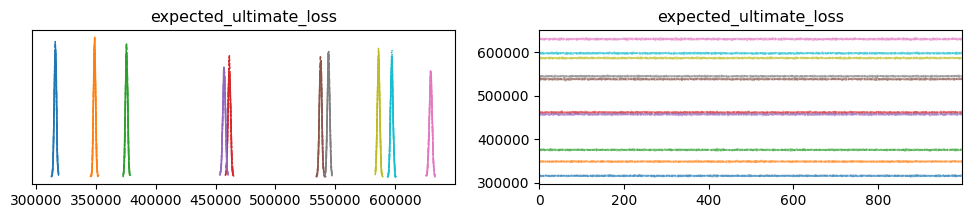

In [21]:
az.plot_trace(trace, var_names=['expected_ultimate_loss'])

In [37]:
(100*az.summary(trace, var_names=['beta_paid'])['mean']).round(1).tolist()

[9.2, 29.9, 52.1, 70.2, 82.2, 99.8, 100.0, 100.0, 100.0, 100.0]

array([[<Axes: title={'center': 'beta_rpt\n0'}>,
        <Axes: title={'center': 'beta_rpt\n1'}>,
        <Axes: title={'center': 'beta_rpt\n2'}>],
       [<Axes: title={'center': 'beta_rpt\n3'}>,
        <Axes: title={'center': 'beta_rpt\n4'}>,
        <Axes: title={'center': 'beta_rpt\n5'}>],
       [<Axes: title={'center': 'beta_rpt\n6'}>,
        <Axes: title={'center': 'beta_rpt\n7'}>,
        <Axes: title={'center': 'beta_rpt\n8'}>],
       [<Axes: title={'center': 'beta_rpt\n9'}>, <Axes: >, <Axes: >]],
      dtype=object)

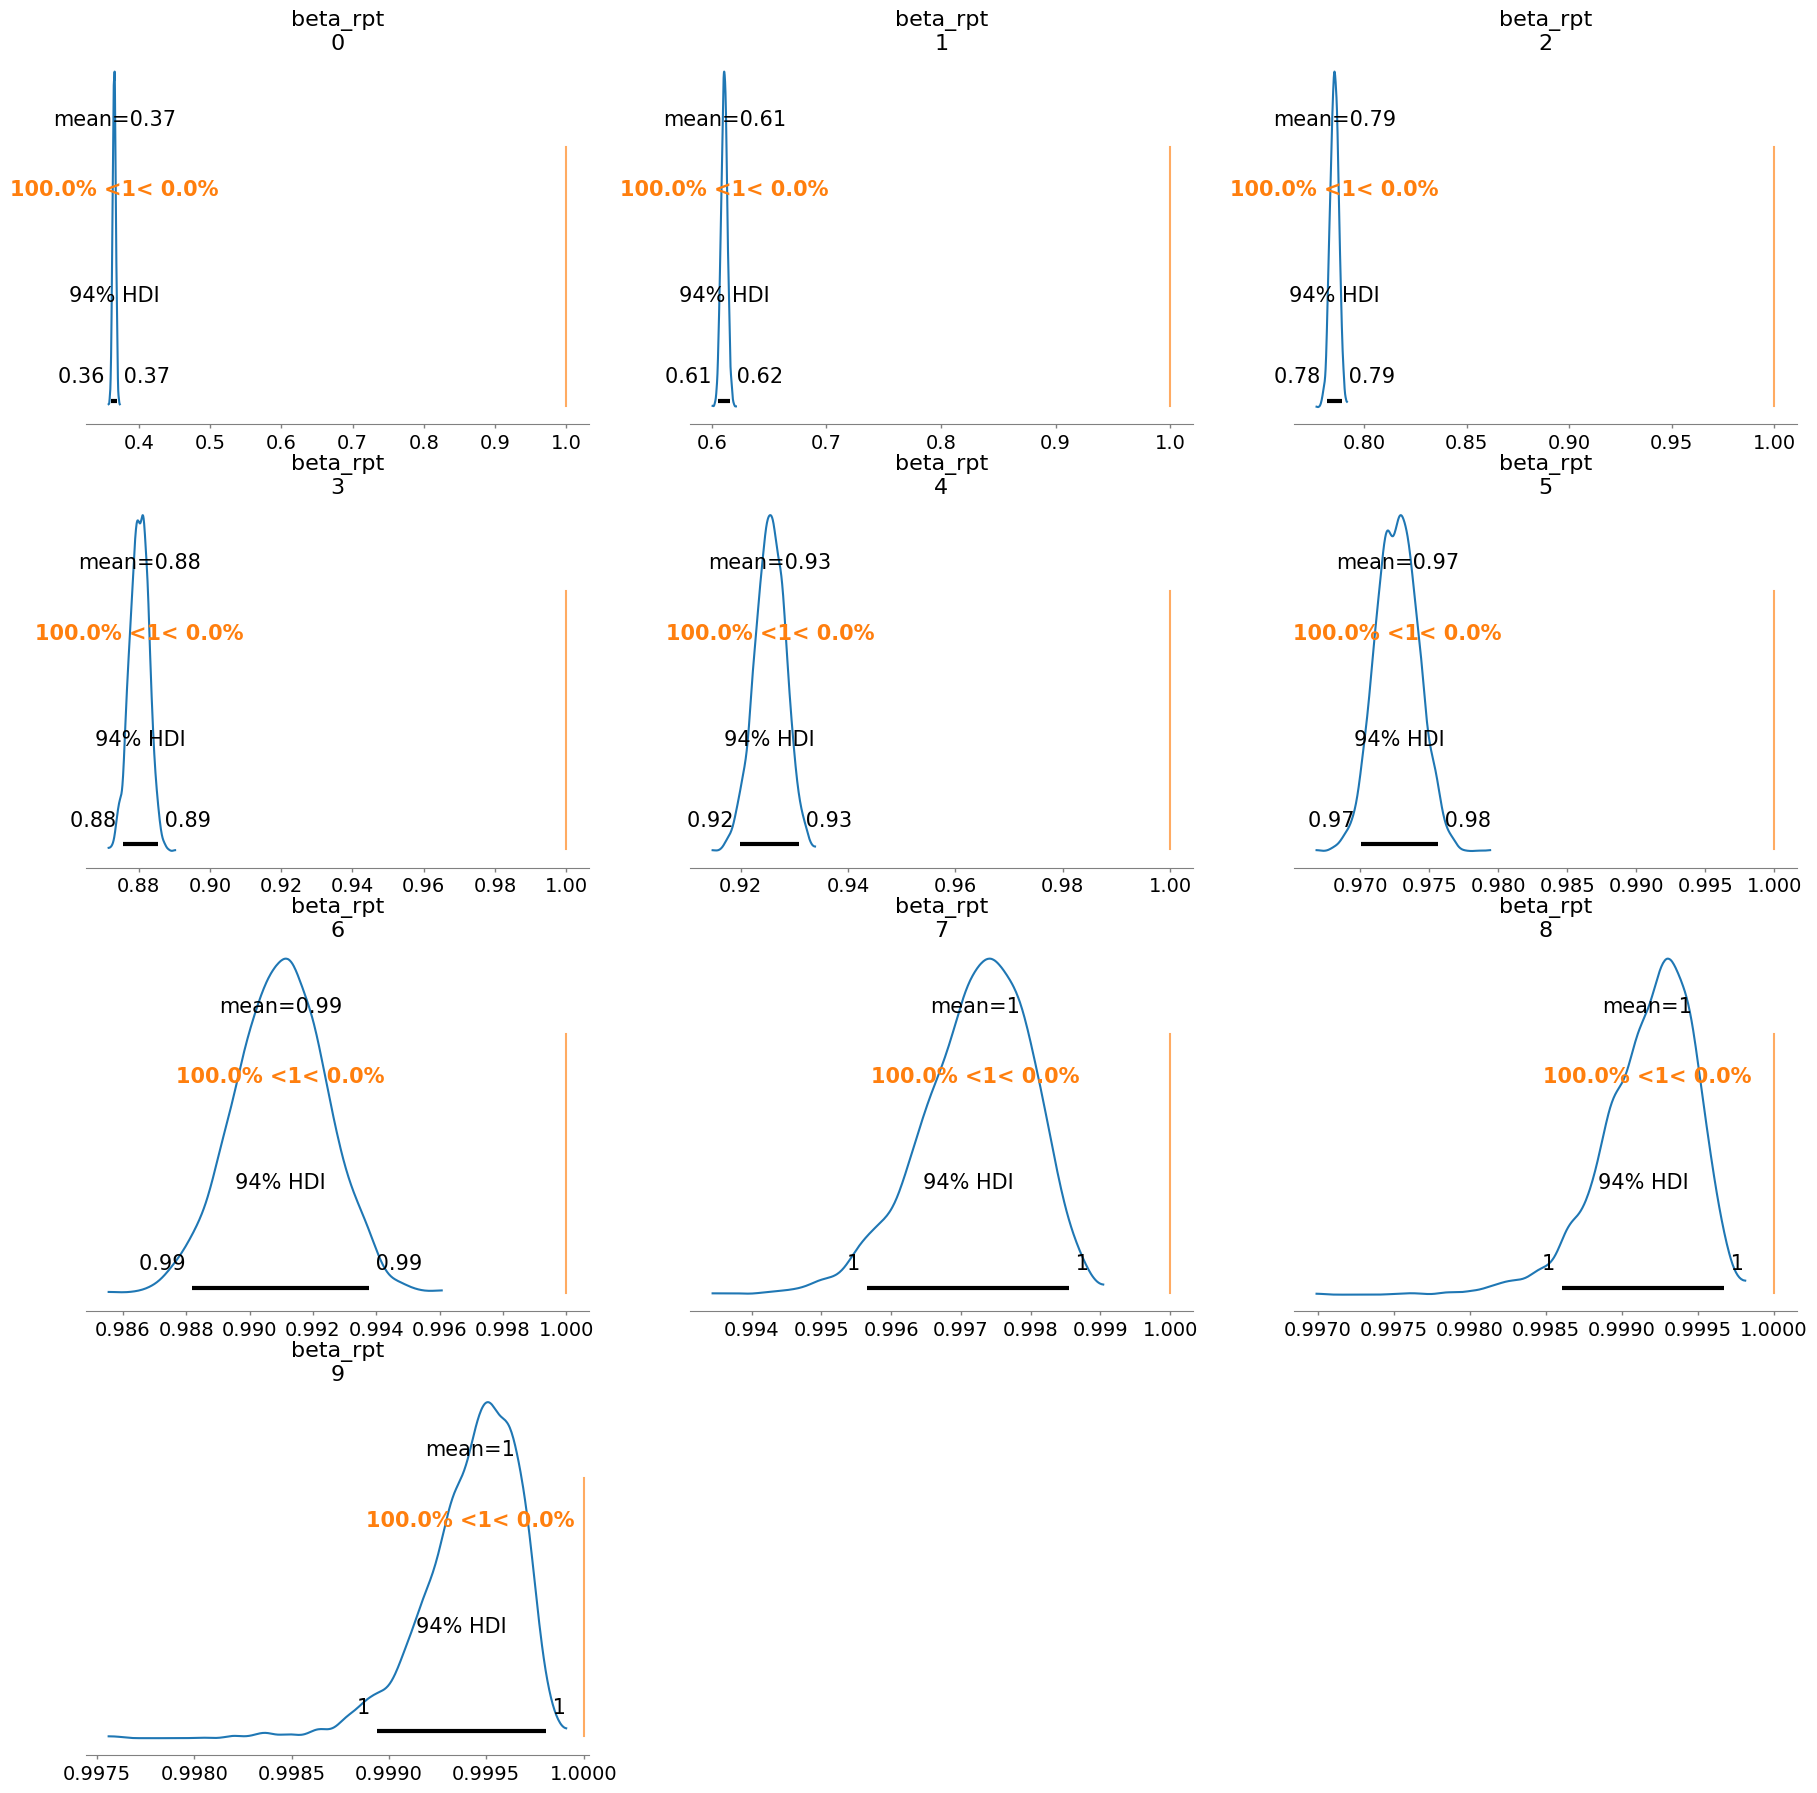

In [46]:
az.plot_posterior(trace, var_names=['beta_rpt'], ref_val=1)